In [1]:
from keras.models import Sequential, Model, load_model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda, UpSampling2D
from keras.layers import Add, merge, DepthwiseConv2D, GlobalAveragePooling2D, Dropout
from keras.layers.merge import add, concatenate
from keras.optimizers import SGD, Adam, RMSprop
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from model import ResNet152
import numpy as np
from skimage.io import imread
from skimage.transform import resize
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 
import cv2
import os

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## path setting 

In [2]:
train_path = './skinimg/train'
valid_path = './skinimg/valid'
test_path = './skinimg/test'

## Image load

In [3]:
train_dataGen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='reflect')
test_dataGen = ImageDataGenerator(rescale=1./255)
train_batches = train_dataGen.flow_from_directory(train_path, 
                                            target_size=(1024,1024), 
                                            color_mode='rgb', 
                                            classes=['A', 'B', 'C'], 
                                            batch_size=9, 
                                            shuffle=True)
valid_batches = test_dataGen.flow_from_directory(valid_path, 
                                            target_size=(1024,1024), 
                                            color_mode='rgb', 
                                            classes=['A', 'B', 'C'], 
                                            batch_size=3, 
                                            shuffle=True)
test_batches = test_dataGen.flow_from_directory(test_path, 
                                           target_size=(1024,1024), 
                                            batch_size=1, 
                                            shuffle=False)

Found 27 images belonging to 3 classes.
Found 9 images belonging to 3 classes.
Found 15 images belonging to 1 classes.


## test data augmentation

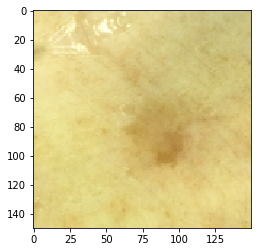

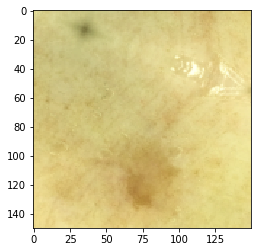

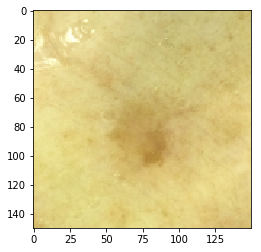

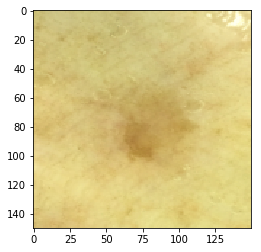

In [4]:
from keras.preprocessing import image # 影象預處理模組

train_A = './skinimg/train/A'
fnames = [os.path.join(train_A, fname) for fname in os.listdir(train_A)]
img_path = fnames[3] # 選擇一張圖片進行增強
img = image.load_img(img_path, target_size=(150, 150)) # 讀取影象並調整大小
x = image.img_to_array(img) # 形狀轉換為(150,150,3)的Numpy陣列
x = x.reshape((1,) + x.shape)

i = 0
# 生成隨機變換後圖像批量，迴圈是無限生成，也需要我們手動指定終止條件
for batch in train_dataGen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
plt.show()

## Build model 

In [3]:
base_model = ResNet152(include_top=False, weights='imagenet',
              input_tensor=None, input_shape=None, pooling=None, classes=1000)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
out = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=out)

In [6]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_zeropadding (ZeroPadding2 (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9408        conv1_zeropadding[0][0]          
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
scale_conv

In [6]:
for i, layer in enumerate(model.layers):
      print(i, layer.name)

0 input_1
1 conv1_zeropadding
2 conv1
3 bn_conv1
4 scale_conv1
5 conv1_relu
6 pool1
7 res2a_branch2a
8 bn2a_branch2a
9 scale2a_branch2a
10 res2a_branch2a_relu
11 res2a_branch2b_zeropadding
12 res2a_branch2b
13 bn2a_branch2b
14 scale2a_branch2b
15 res2a_branch2b_relu
16 res2a_branch2c
17 res2a_branch1
18 bn2a_branch2c
19 bn2a_branch1
20 scale2a_branch2c
21 scale2a_branch1
22 res2a
23 res2a_relu
24 res2b_branch2a
25 bn2b_branch2a
26 scale2b_branch2a
27 res2b_branch2a_relu
28 res2b_branch2b_zeropadding
29 res2b_branch2b
30 bn2b_branch2b
31 scale2b_branch2b
32 res2b_branch2b_relu
33 res2b_branch2c
34 bn2b_branch2c
35 scale2b_branch2c
36 res2b
37 res2b_relu
38 res2c_branch2a
39 bn2c_branch2a
40 scale2c_branch2a
41 res2c_branch2a_relu
42 res2c_branch2b_zeropadding
43 res2c_branch2b
44 bn2c_branch2b
45 scale2c_branch2b
46 res2c_branch2b_relu
47 res2c_branch2c
48 bn2c_branch2c
49 scale2c_branch2c
50 res2c
51 res2c_relu
52 res3a_branch2a
53 bn3a_branch2a
54 scale3a_branch2a
55 res3a_branch2a_re

## Training 

In [4]:
for layer in model.layers[:-4]:
    layer.trainable=False
for layer in model.layers[-4:]:
    layer.trainable=True

In [9]:
train_batches.batch_size

9

In [12]:
%%time
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy

step_size_train = 5 #train_batches.n // train_batches.batch_size
model.fit_generator(generator=train_batches, 
                    steps_per_epoch=step_size_train, 
                    validation_data=valid_batches, 
                    validation_steps=1, 
                    epochs=100, 
                    verbose=2)

Epoch 1/100
 - 20s - loss: 0.4261 - acc: 0.8222 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2/100
 - 15s - loss: 0.2863 - acc: 0.9333 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3/100
 - 16s - loss: 0.0629 - acc: 0.9778 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4/100
 - 16s - loss: 0.1540 - acc: 0.9333 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 5/100
 - 16s - loss: 0.0536 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 6/100
 - 16s - loss: 0.1185 - acc: 0.9556 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 7/100
 - 16s - loss: 0.0312 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 8/100
 - 16s - loss: 0.0866 - acc: 0.9778 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 9/100
 - 16s - loss: 0.1076 - acc: 0.9333 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 10/100
 - 16s - loss: 0.0446 - acc: 0.9778 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 11/100
 - 16s - loss: 0.0590 - acc: 0.9778 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 12/100
 - 16s

 - 16s - loss: 0.0026 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 93/100
 - 16s - loss: 0.0198 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 94/100
 - 15s - loss: 0.0304 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 95/100
 - 16s - loss: 0.0081 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 96/100
 - 15s - loss: 0.0144 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 97/100
 - 15s - loss: 0.0123 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 98/100
 - 16s - loss: 0.0096 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 99/100
 - 16s - loss: 0.0024 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 100/100
 - 16s - loss: 0.0127 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
CPU times: user 30min 57s, sys: 1min 44s, total: 32min 42s
Wall time: 26min 3s


ResNet152_fc_512_3_size1024_epochs_100_batch_9_valid_9

## Save model

In [27]:
# model.save_weights('./weight/ResNet152_fc_512_3_size1024_epochs_100_batch_9_valid_9.h5')
model.load_weights('./weight/ResNet152_fc_512_3_size1024_epochs_100_batch_9_valid_9.h5')

## Report 

In [34]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

dataGen = ImageDataGenerator(rescale=1./255)
train_batches = dataGen.flow_from_directory(train_path, 
                                            target_size=(1024,1024), 
                                            color_mode='rgb', 
                                            classes=['A', 'B', 'C'], 
                                            batch_size=9, 
                                            shuffle=False)
valid_batches = dataGen.flow_from_directory(valid_path, 
                                            target_size=(1024,1024), 
                                            color_mode='rgb', 
                                            classes=['A', 'B', 'C'], 
                                            batch_size=3, 
                                            shuffle=False)

train_pred = model.predict_generator(generator=train_batches, verbose=1)
valid_pred = model.predict_generator(generator=valid_batches, verbose=1)

train_label = train_batches.classes
train_pred = np.argmax(train_pred, axis=1)
valid_label = valid_batches.classes
valid_pred = np.argmax(valid_pred, axis=1)



Found 27 images belonging to 3 classes.
Found 9 images belonging to 3 classes.
3/3 [==============================] - 4s 1s/step


In [33]:
print(train_label)
print(train_pred)
print(valid_label)
print(valid_pred)

[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2]
[0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 1 1 1 2 2 2]
[1 1 1 0 0 0 0 0 0]


[train reports]
             precision    recall  f1-score   support

          A       0.33      1.00      0.50         9
          B       0.00      0.00      0.00         9
          C       0.00      0.00      0.00         9

avg / total       0.11      0.33      0.17        27
   accuracy       0.33

[valid reports]
             precision    recall  f1-score   support

          A       0.33      1.00      0.50         3
          B       0.00      0.00      0.00         3
          C       0.00      0.00      0.00         3

avg / total       0.11      0.33      0.17         9
   accuracy       0.33


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


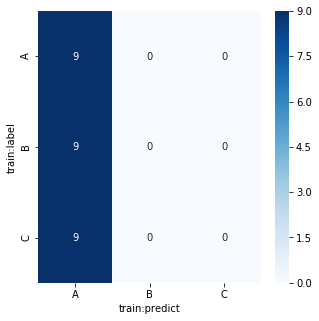

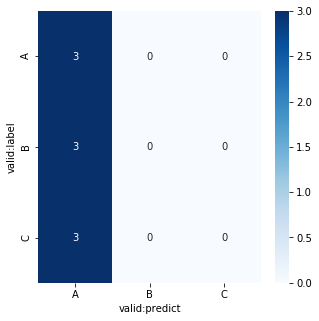

In [35]:
import pandas as pd
import seaborn as sn
def show_confusion_matrix(confmat, dataType):
    df_cm = pd.DataFrame(confmat, index = [i for i in "ABC"],
                  columns = [i for i in "ABC"])
    plt.figure(figsize = (5,5))
    sn.heatmap(df_cm, annot=True, cmap=plt.cm.Blues)
    plt.xlabel(dataType + ':predict')        
    plt.ylabel(dataType + ':label')
    plt.savefig("./others/" + dataType + ".png")
    plt.show()


label = dict((v,k) for k,v in train_batches.class_indices.items())
train_report = classification_report(train_label, train_pred, target_names=['A', 'B', 'C'])
train_accuracy = accuracy_score(train_label, train_pred)
valid_report = classification_report(valid_label, valid_pred, target_names=['A', 'B', 'C'])
valid_accuracy = accuracy_score(valid_label, valid_pred)
train_mat = confusion_matrix(train_label, train_pred)
valid_mat = confusion_matrix(valid_label, valid_pred)

print("[train reports]")
print(train_report, "{:>10}{:11.2f}".format("accuracy", train_accuracy))
print('')
print("[valid reports]")
print(valid_report, "{:>10}{:11.2f}".format("accuracy", valid_accuracy))

show_confusion_matrix(train_mat, 'train')
show_confusion_matrix(valid_mat, 'valid')




## testing

In [8]:
test_batches.reset()
pred = model.predict_generator(generator=test_batches, verbose=1)

labels = (train_batches.class_indices)
label = dict((v,k) for k,v in labels.items())

filename = test_batches.filenames
pred_label = np.argsort(pred, axis=1)[:, ::-1][:, :3]
for i in range(15):
    print('{:<20}'.format(filename[i]), end='')
    for j in pred_label[i]:
        print(label[j], end='')
        print("%7.2f%%  " % (pred[i, j] * 100), end='')
    print('')

NameError: name 'test_batches' is not defined

## Others 

In [ ]:
# create model
model = ResNet152()
print(model.get_config())
# define function for input preprocessing
def preprocess(x):
    x = resize(x, (224,224), mode='constant') * 255
    x = preprocess_input(x)
    if x.ndim == 3:
        x = np.expand_dims(x, 0)
    return x

# prepare image
img = imread('./cat.jpg')
x = preprocess(img)

# make prediction and decode it
y = model.predict(x)
pred_title = decode_predictions(y, top=1)[0][0][1]

# print result
print(pred_title)